## Exploration

train.csv shape is  (139753, 9)
test.csv shape is  (13976, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0  1049849  B000MR9D5E  A1EKSETIBS9ETQ                     0   
1   999834  B000GAKFIG   AR0HFYHYHDGQQ                     2   
2   218826  6300215776  A37S3ACL57LN62                    11   
3   796384  B00019071C  A1TO1P3NV7OAU6                     2   
4  1219784  B001NFNFN0   ATCM1W7HWIC6U                     0   

   HelpfulnessDenominator        Time  \
0                       0  1198281600   
1                       5  1245024000   
2                      15  1126137600   
3                       2  1351036800   
4                       0  1381708800   

                                             Summary  \
0  Great nature series, but not all scenes looked...   
1                 Agatha Christie's Marple: Series 2   
2                             Childish Entertainment   
3                       The weakest Babylon 5 season   
4                        

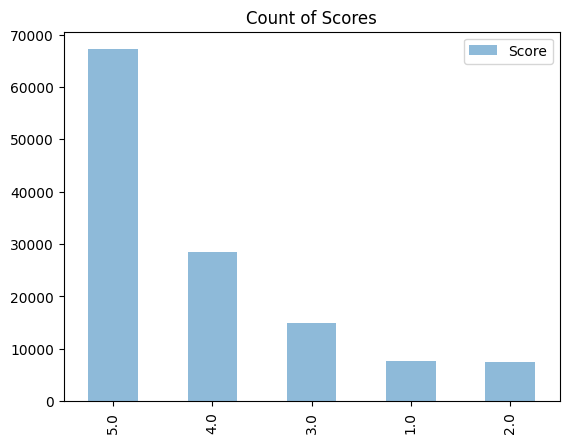

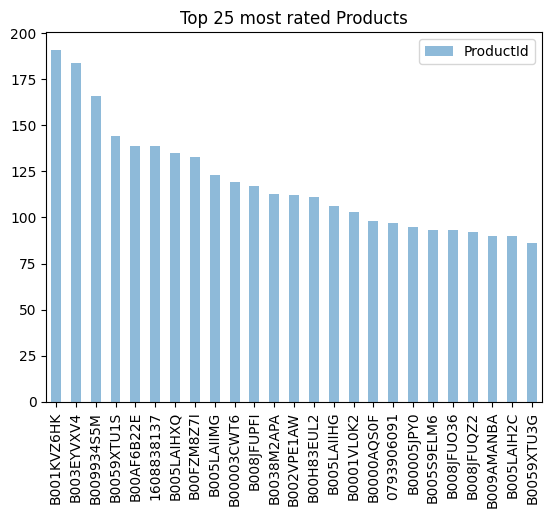

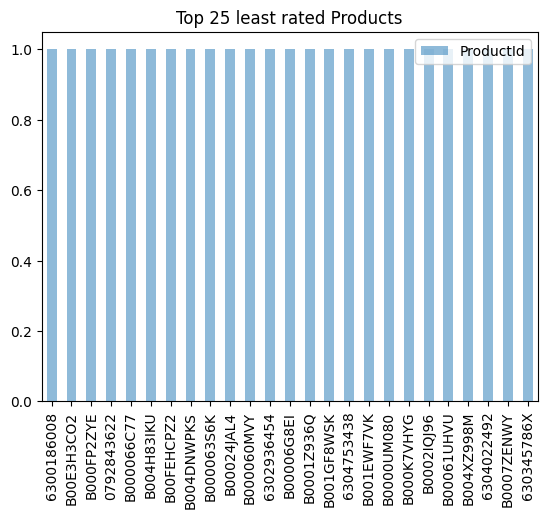

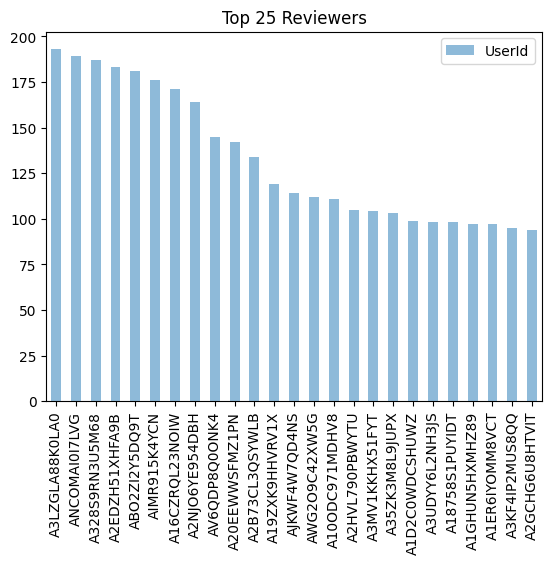

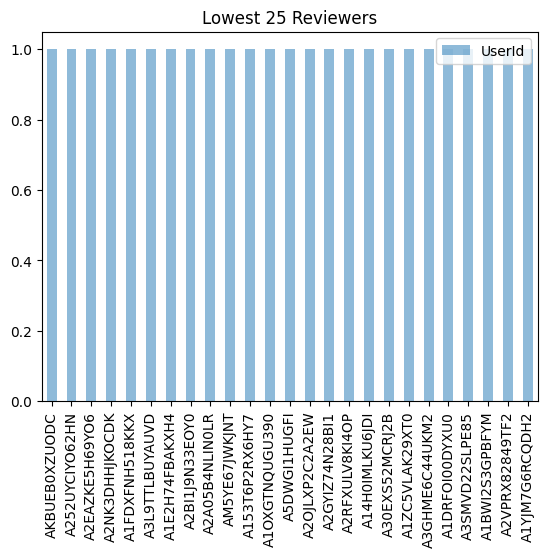

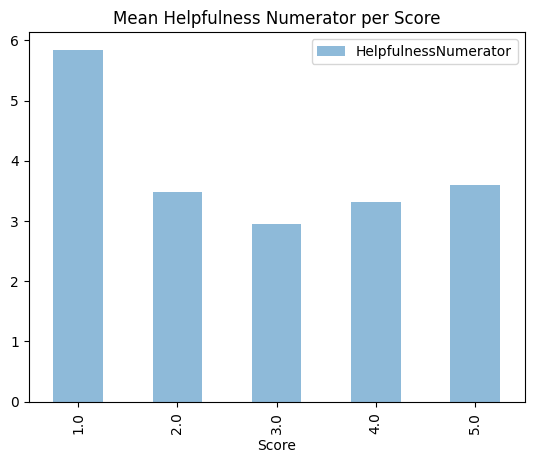

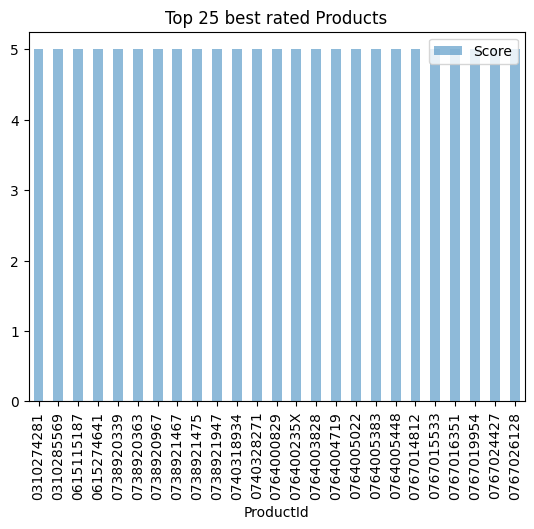

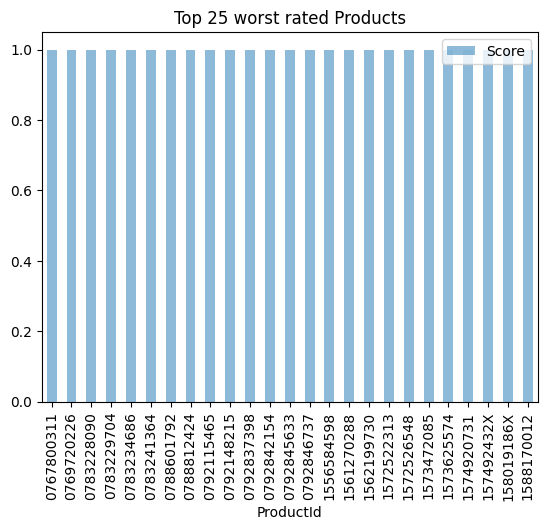

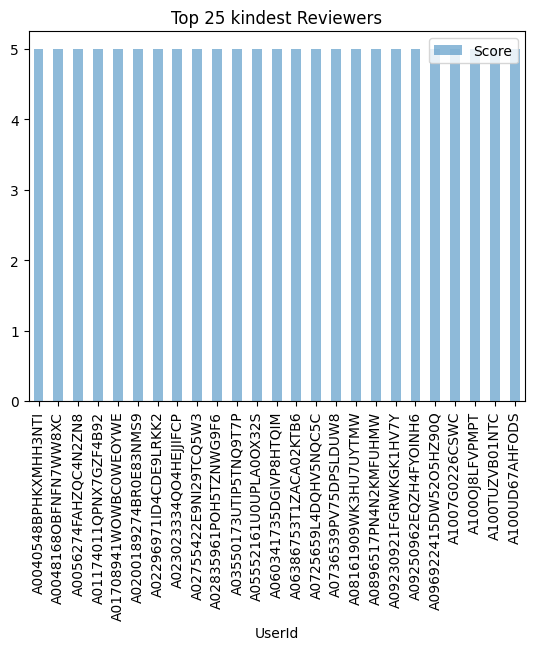

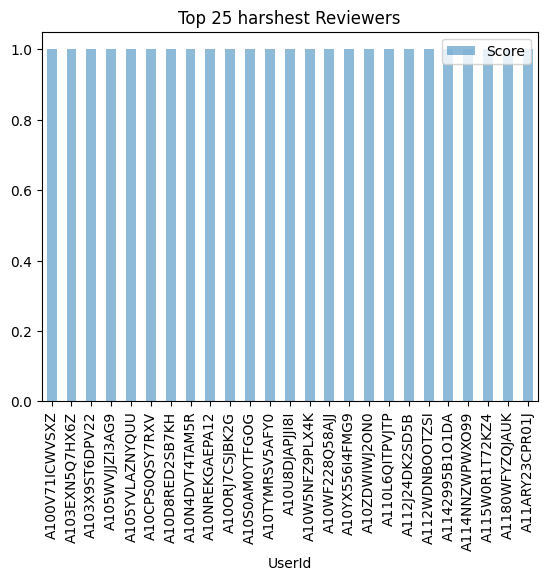

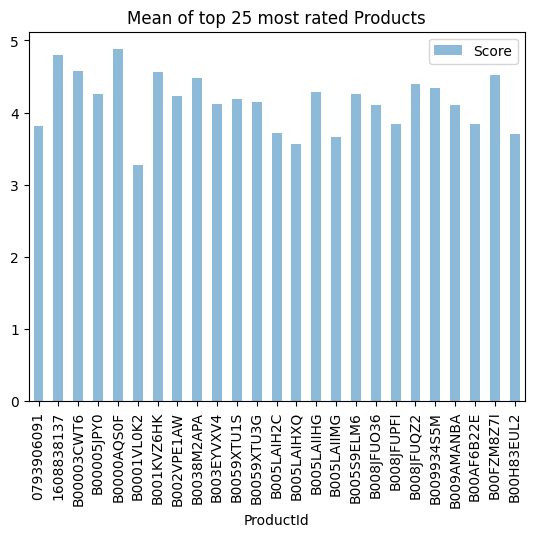

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 most rated Products")
plt.show()

trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 least rated Products")
plt.show()

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers")
plt.show()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers")
plt.show()

trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 best rated Products")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 worst rated Products")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 kindest Reviewers")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 harshest Reviewers")
plt.show()

trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean of top 25 most rated Products")
plt.show()

## Feature Extraction

In [25]:
import pandas as pd

def process(df):
    # This is where you can do all your processing

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)

    return df

# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)


## Creating your model

        HelpfulnessNumerator  HelpfulnessDenominator        Time  Helpfulness  \
115330                     0                       0  1388534400     0.000000   
17624                      1                       2  1371168000     0.500000   
30519                      1                       1  1205798400     1.000000   
8247                     146                     151  1195862400     0.966887   
36131                      0                       1  1356393600     0.000000   
16942                      0                       0  1356307200     0.000000   
54461                      0                       2  1365638400     0.000000   
75120                      0                       0  1350259200     0.000000   
27172                      1                       1  1364342400     1.000000   
50698                      1                       1  1364774400     1.000000   

        ReviewLength  
115330            35  
17624             22  
30519             20  
8247            

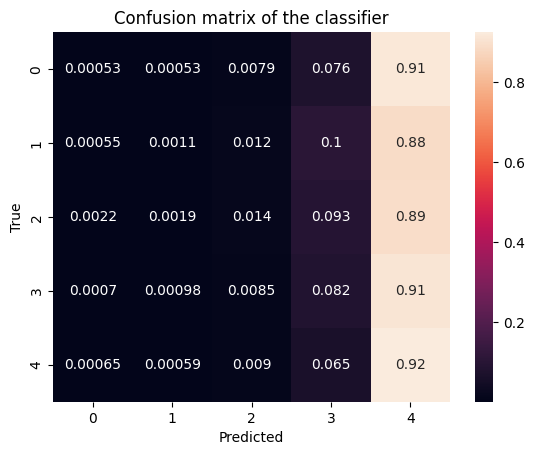

In [26]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])

print(X_train_processed.head(10))

# Learn the model
model = KNeighborsClassifier(n_neighbors=20).fit(X_train_processed, Y_train)

# pickle model - saves it so you can load it later
with open('knn_20_model.obj', 'wb') as f:
        pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions, squared = False))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [23]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

X_submission['Score'] = model.predict(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

Now you can upload the `submission.csv` to kaggle